Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

Load Dataset

In [ ]:
data = pd.read_csv('/content/Fraud.csv')



In [ ]:
data.head()

In [ ]:
print(data.info())

In [ ]:
print(data.describe())

In [ ]:
print("Distribution of Target Variable:")
print(data['isFraud'].value_counts())  # Display count of each class

Checking Null values

In [ ]:
# Check for missing values
print(data.isnull().sum())


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


Filling 0 in place of null values

In [ ]:
# Fill missing values with 0
data.fillna(0, inplace=True)



<ipython-input-21-4e9be39914bb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='type', palette='Set2')


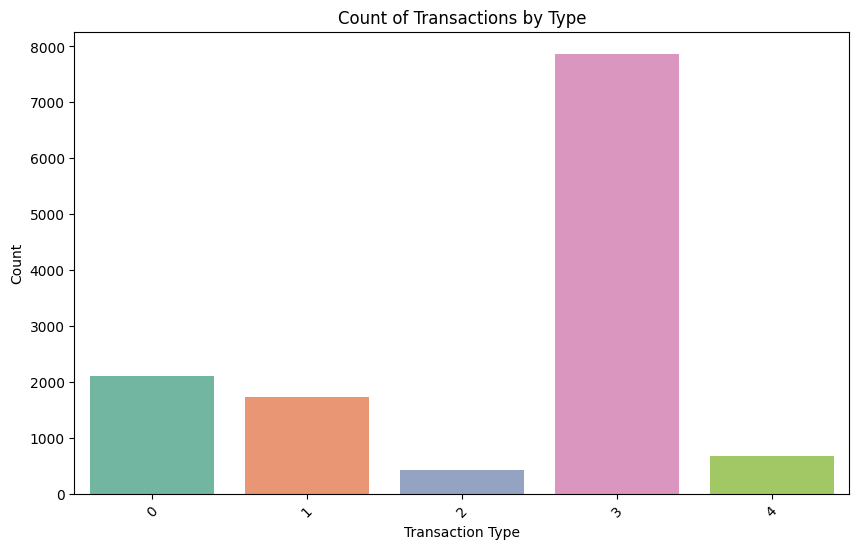

In [ ]:
# EDA on the 'type' column
# Count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='type', palette='Set2')
plt.title("Count of Transactions by Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

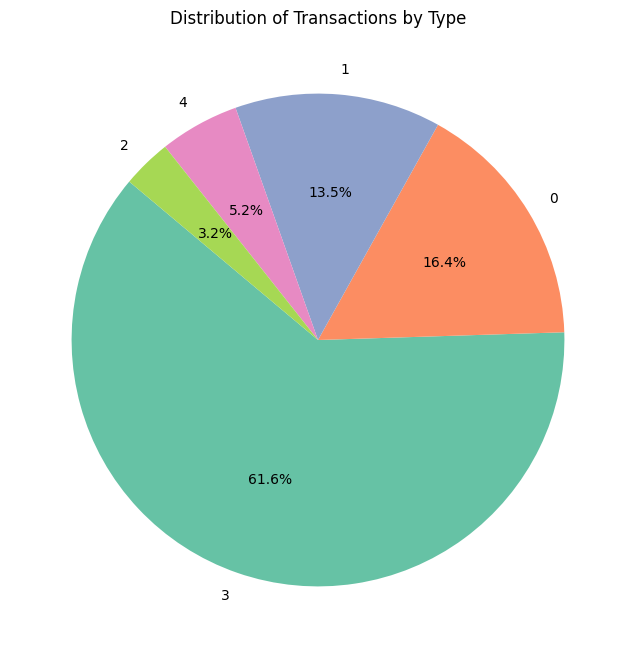

In [ ]:
# Pie chart
plt.figure(figsize=(8, 8))
data['type'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('Set2'), startangle=140)
plt.title("Distribution of Transactions by Type")
plt.ylabel("")
plt.show()

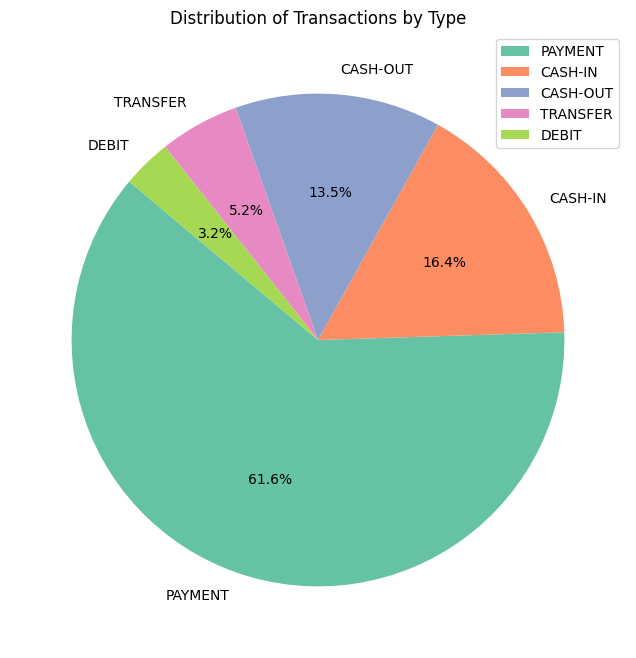

In [ ]:
# Mapping numerical values to transaction types
type_mapping = {0: 'CASH-IN', 1: 'CASH-OUT', 2: 'DEBIT', 3: 'PAYMENT', 4: 'TRANSFER'}

# Convert numerical values to transaction types
data['type_labels'] = data['type'].map(type_mapping)

# Pie chart
plt.figure(figsize=(8, 8))
data['type_labels'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('Set2'), startangle=140)
plt.title("Distribution of Transactions by Type")
plt.ylabel("")

# Add legend
plt.legend(data['type_labels'].value_counts().index, loc='best')

plt.show()


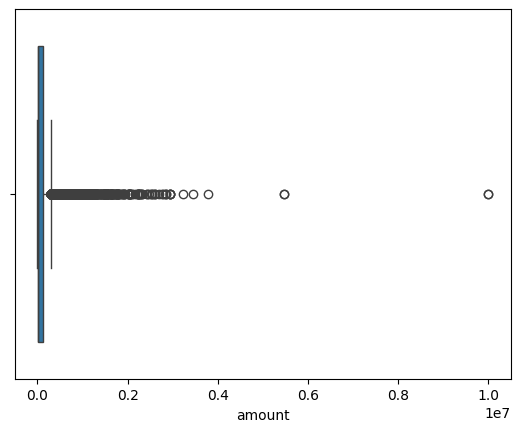

In [ ]:
# Visualize distributions to identify outliers
sns.boxplot(x=data['amount'])
plt.show()

Remove Outliers

In [ ]:
Q1 = data['amount'].quantile(0.25)
Q3 = data['amount'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['amount'] < (Q1 - 1.5 * IQR)) | (data['amount'] > (Q3 + 1.5 * IQR)))]


In [ ]:
# Create new features
data['diffOrig'] = data['newbalanceOrig'] - data['oldbalanceOrg']
data['diffDest'] = data['newbalanceDest'] - data['oldbalanceDest']


In [ ]:
# Convert categorical 'type' column to numeric
le = LabelEncoder()
data['type'] = le.fit_transform(data['type'])

In [ ]:
# Drop irrelevant columns
data.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)


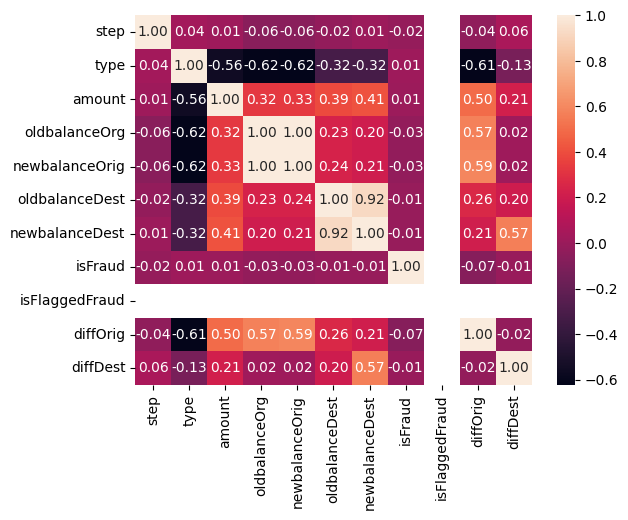

In [ ]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.show()

In [ ]:
# Define features and target
X = data.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = data['isFraud']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:

# Train DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 4: Model Evaluation
# Predict on test data
y_pred = clf.predict(X_test)

# Convert predictions to "Yes" or "No"
y_pred_label = np.where(y_pred == 1, "Yes", "No")

# Print out predictions
print(y_pred_label)


['No' 'No' 'No' ... 'No' 'No' 'No']


In [ ]:

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3812
         1.0       0.69      0.55      0.61        20

    accuracy                           1.00      3832
   macro avg       0.84      0.77      0.80      3832
weighted avg       1.00      1.00      1.00      3832



We are using a Random Forest classifier to detect fraudulent transactions. This model is chosen for its high accuracy and ability to handle large datasets with complex relationships between features.


The feature importances indicate the contribution of each feature to the model. Higher importance values suggest that the feature has a stronger impact on the prediction of fraud.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 6: Model Evaluation
# Predict on test data
y_pred =rf.predict(X_test)




In [ ]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3812
         1.0       0.92      0.60      0.73        20

    accuracy                           1.00      3832
   macro avg       0.96      0.80      0.86      3832
weighted avg       1.00      1.00      1.00      3832



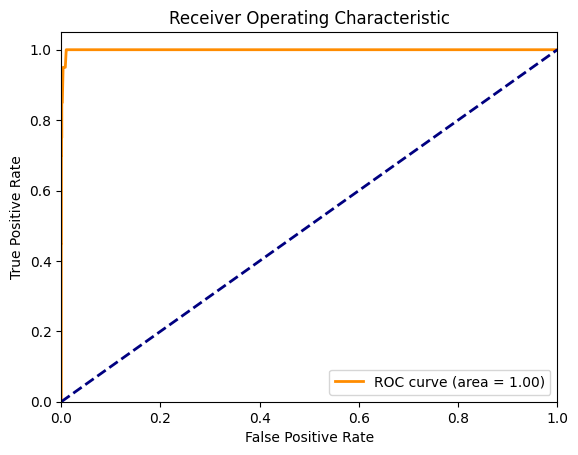

In [ ]:
y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:

data['prediction'] = rf.predict(X)

# Convert numeric predictions to string labels ('yes' or 'no')
data['prediction'] = data['prediction'].apply(lambda x: 'Yes' if x == 1 else 'No')

# Save the modified DataFrame with predicted labels to a CSV file
data.to_csv('predicted_fraud.csv', index=False)


print(data['prediction'].head(50))


0      No
1      No
2     Yes
3      No
4      No
5      No
6      No
7      No
8      No
9      No
10     No
11     No
12     No
13     No
14     No
15     No
16     No
17     No
18     No
19     No
20     No
21     No
22     No
23     No
25     No
26     No
27     No
28     No
29     No
30     No
31     No
32     No
33     No
34     No
35     No
36     No
37     No
38     No
39     No
40     No
41     No
42     No
43     No
44     No
45     No
46     No
47     No
48     No
49     No
50     No
Name: prediction, dtype: object


Features that predict fraudulent customer

1.Transaction behaviour
2.Insufficient information that tracstion is taking place.
3.Geographical Information
4.Receipt account balance is not available for Merchant account2.


 Prevention Recommendations

1. Implement real-time transaction monitoring and alerts for suspicious activities.
2. Enhance authentication mechanisms such as two-factor authentication.
3. Regularly update security protocols and perform penetration testing.
4. Educate customers about common fraud schemes and prevention tips.